In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
#%matplotlib nbagg

from scipy.stats import norm
from scipy.stats import bernoulli
import tqdm

xrange = np.arange(-10, 10, 0.01)
xmin = xrange.min()
xmax = xrange.max()
xlim = (xmin, xmax)

In [31]:
def get_normal_dist_pde(x, mu, sigma):
    #if sigma == 0:
    #    sigma = 0.0000001
    #return np.exp( -np.power(x-mu, 2)/(2*sigma**2) ) / (np.sqrt(2*np.pi)*sigma)
    return norm.pdf(x, mu, sigma)

def get_mix_normal_dist_sample(num_sampling, pi, mu, sigma):
    ps = bernoulli.rvs(pi[0], size=num_sampling)
    #y = np.array([pi[0]*np.random.normal(mu[0], sigma[0]) if p==1 else pi[1]*np.random.normal(mu[1], sigma[1]) for p in ps]) 
    y = np.array([np.random.normal(mu[0], sigma[0]) if p==1 else np.random.normal(mu[1], sigma[1]) for p in ps]) 
    return y

def plot_mix_normal_dist(pi, mu, sigma, xrange):
    ress = []
    for x in xrange:
        res = np.array([pi[i]*get_normal_dist_pde(x, mu[i], sigma[i]) for i in range(len(pi))])
        ress.append(np.sum(res))
    im =plt.scatter(xrange,ress)
    return im

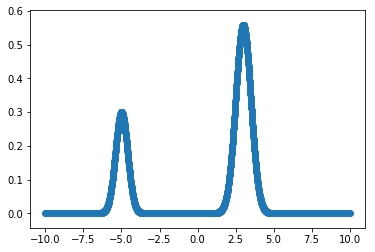

In [35]:
# Sampling
## y ~ \dot_{i=0}^{1} N(mu_i, sigma_i)^{k_i}
## k_0 + k_1 = 1
## k_0 = 1となる確率pi_[0], k_1 = 1となる確率pi_[1]

# parameters
pi_true = [0.3, 0.7]
mu_true = [-5.0, 3.0]
sigma_true = [0.4, 0.5]

# sampling
num_sampling = 1000
#k = bernoulli.rvs(pi[0], size=num_sampling)
#y = np.array([np.random.normal(mu[0], sigma[0]) if k_val == 0 else np.random.normal(mu[1], sigma[1]) for k_val in k])
y = get_mix_normal_dist_sample(num_sampling=num_sampling, pi=pi_true, mu=mu_true, sigma=sigma_true)
#y = np.array([get_normal_dist_pde(x, mu_true[0], sigma_true[0])+np.random.normal(0,0.01) if bernoulli.rvs(pi[0])==1 else get_normal_dist_pde(x, mu_true[1], sigma_true[1])+np.random.normal(0,0.01) for x in xrange])

# plot
plot_mix_normal_dist(pi_true, mu_true, sigma_true, xrange=xrange)

plt.show()

100%|████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


pi=0.303:0.697, mu=-4.9995337683557475:3.0055760200244963, sigma=0.3918840738252712:0.5005852888854653


Traceback (most recent call last):
  File "C:\Users\033041004\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "C:\Users\033041004\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "C:\Users\033041004\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py", line 1081, in _start
    self._init_draw()
  File "C:\Users\033041004\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\animation.py", line 1617, in _init_draw
    for artist in f:
TypeError: 'PathCollection' object is not iterable


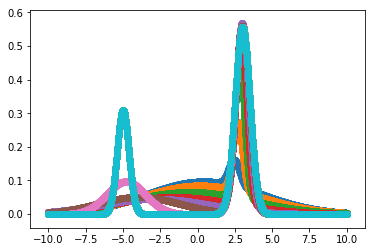

In [39]:
# EM

## parameters(pi, mu, simga)の初期化
pi_est = [0.8, 0.2]
mu_est = [3.0, 2.0]
sigma_est = [0.7, 0.5]

fig = plt.figure()
ims = []
num_iteration = 100
for iter in tqdm.tqdm(range(num_iteration)):
    ## E-Step
    ### p(gamma | pi, mu, sigma)を現在のpi, mu, sigmaから求める
    likelyhood_0 = pi_est[0]*np.array([get_normal_dist_pde(y[i], mu_est[0], sigma_est[0]) for i in range(len(y))])
    likelyhood_1 = pi_est[1]*np.array([get_normal_dist_pde(y[i], mu_est[1], sigma_est[1]) for i in range(len(y))])
    likelyhood = likelyhood_0 + likelyhood_1
    gamma_0 = likelyhood_0 / likelyhood
    gamma_1 = likelyhood_1 / likelyhood

    ## M-Step
    ### log L( pi, mu, simga| gamma)を最大化するpi, mu, sigmaを求める
    N_0 = np.sum(gamma_0)
    N_1 = np.sum(gamma_1)
    pi_est[0] = N_0 / (N_0+N_1)
    pi_est[1] = N_1 / (N_0+N_1)

    assert len(gamma_0)==len(y), 'ng'
    mu_est[0] = np.sum(gamma_0*y) / N_0
    mu_est[1] = np.sum(gamma_1*y) / N_1
    assert len(gamma_0*y)==len(y), 'ng1'
    
    y_0 = np.power(y-mu_est[0], 2)
    assert len(y_0)==len(y), 'ng2'
    sigma_est[0] = np.sqrt(np.sum(gamma_0*y_0) / N_0)
    y_1 = np.power(y-mu_est[1], 2)
    sigma_est[1] = np.sqrt(np.sum(gamma_1*y_1) / N_1)
    

    ## Plot
    #plot_mix_normal_dist(pi, mu, sigma, xrange=xrange)
    im = plot_mix_normal_dist(pi_est, mu_est, sigma_est, xrange=xrange)
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=500)
print(f'pi={pi_est[0]}:{pi_est[1]}, mu={mu_est[0]}:{mu_est[1]}, sigma={sigma_est[0]}:{sigma_est[1]}')
#plot_mix_normal_dist(pi=pi_est, mu=mu_est, sigma=sigma_est, xrange=xrange)
#plot_mix_normal_dist(pi_true, mu_true, sigma_true, xrange=xrange)

plt.show()

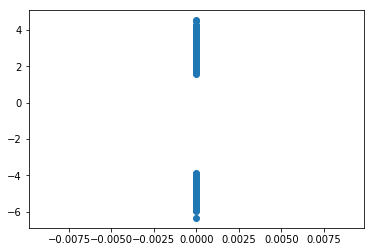

In [36]:
plt.scatter(np.zeros_like(y), y)
plt.show()